**1. Importing Libraries:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,GRU, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

**2. Loading and Preprocessing Data:**

In [ ]:
# Load the data
df = pd.read_excel('/content/finaldata2.xlsx', index_col='date', parse_dates=True)
df = df[::-1]

In [ ]:

# Data preprocessing
df['Aluminium'] = df['Aluminium'].astype(str)
df['Aluminium'] = df['Aluminium'].str.replace(',', '')
df['Aluminium'] = df['Aluminium'].str.replace('-', '')
df['Aluminium'] = df['Aluminium'].replace('NaN', method='bfill')
df['Aluminium'] = pd.to_numeric(df['Aluminium'], errors='coerce')
df.ffill(inplace=True)

In [ ]:
df.head()

,Aluminium
date,
2008-01-02,2365.5
2008-01-03,2422.0
2008-01-04,2447.0
2008-01-07,2404.0
2008-01-08,2442.0


**3. Exploratory Data Analysis (EDA):**

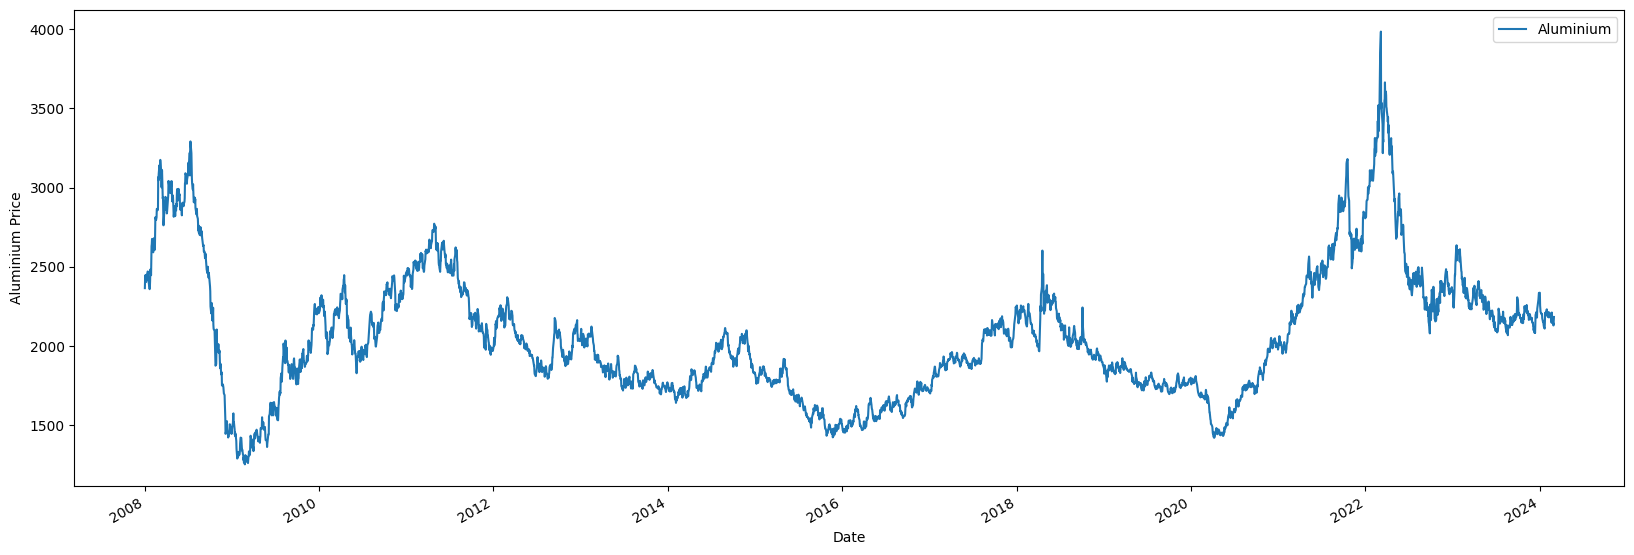

In [ ]:
df.plot(figsize=(20,7))
plt.xlabel('Date')
plt.ylabel('Aluminium Price')
plt.show()

visualizing the trends

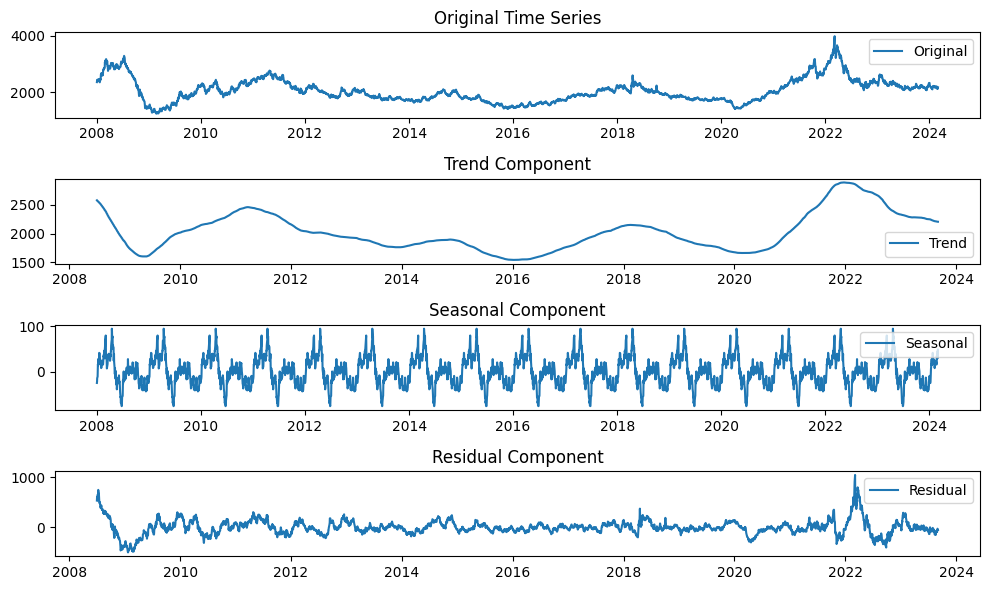

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Apply seasonal decomposition on the data
results = seasonal_decompose(df['Aluminium'], model='additive', period=253)

# Plot the original, trend, seasonal, and residual components
plt.figure(figsize=(10, 6))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(df['Aluminium'], label='Original')
plt.legend()
plt.title('Original Time Series')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(results.trend, label='Trend')
plt.legend()
plt.title('Trend Component')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(results.seasonal, label='Seasonal')
plt.legend()
plt.title('Seasonal Component')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(results.resid, label='Residual')
plt.legend()
plt.title('Residual Component')

plt.tight_layout()
plt.show()


**4. Train-Test Split and Scaling**

In [ ]:
# Train-test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]


In [ ]:
# Scaling
scaler = MinMaxScaler()
scaler.fit(df)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

**5. Data Preparation for LSTM**

In [ ]:
# Reshape data for LSTM
def create_sequences(data, n_input):
    X, y = [], []
    for i in range(len(data) - n_input):
        X.append(data[i:i + n_input])
        y.append(data[i + n_input])
    return np.array(X), np.array(y)

In [ ]:
n_input = 3
X_train, y_train = create_sequences(scaled_train, n_input)
X_test, y_test = create_sequences(scaled_test, n_input)

**6. Building the LSTM Model**

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(n_input, 1)))
model.add(Dropout(0.2))

In [ ]:
model.add(GRU(units=64, return_sequences=True))
model.add(Dropout(0.2))

In [ ]:
model.add(GRU(units=64))
model.add(Dropout(0.1))

In [ ]:
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

**7. Training the Model**

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=4, batch_size=32, verbose=1)


Epoch 1/4
103/103 [==============================] - 8s 14ms/step - loss: 0.0423
Epoch 2/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0192
Epoch 3/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0167
Epoch 4/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0177


**8. Plotting Training Loss**

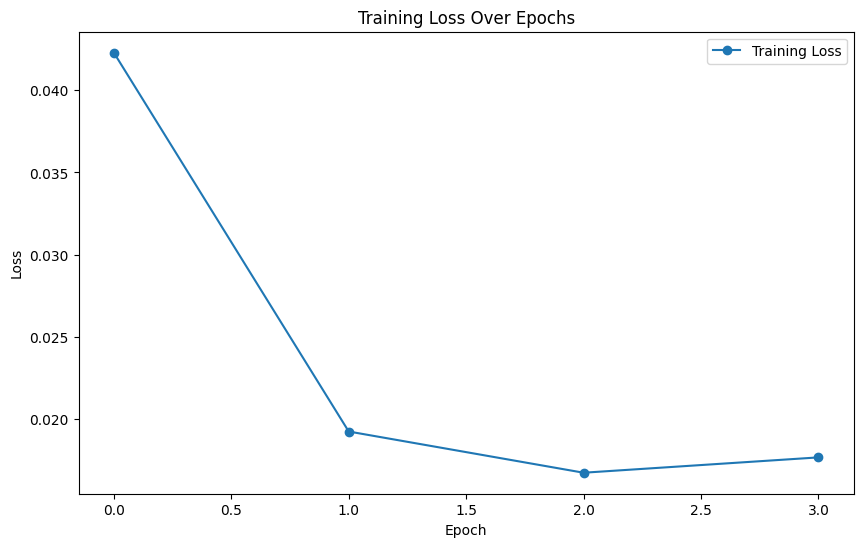

In [ ]:
# Extract training loss from the history
train_loss_history = history.history['loss']

# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**9. Model Evaluation and Prediction**

**10. Making Predictions and Plotting Results**

In [ ]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


26/26 [==============================] - 0s 3ms/step


In [ ]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Training MSE: {train_loss}')
print(f'Testing MSE: {test_loss}')

Training MSE: 0.010012304410338402
Testing MSE: 0.015164026990532875


In [ ]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Calculate MAE, MSE, MAPE for training set
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100

print(f'Training MAE: {train_mae:.4f}')
print(f'Training MAPE: {train_mape:.4f}%')

Training MAE: 27.3436
Training MAPE: 1.3917%


In [ ]:
# Calculate MAE, MSE, MAPE for testing set
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

print(f'Testing MAE: {test_mae:.4f}')
print(f'Testing MAPE: {test_mape:.4f}%')

Testing MAE: 41.4130
Testing MAPE: 1.6300%


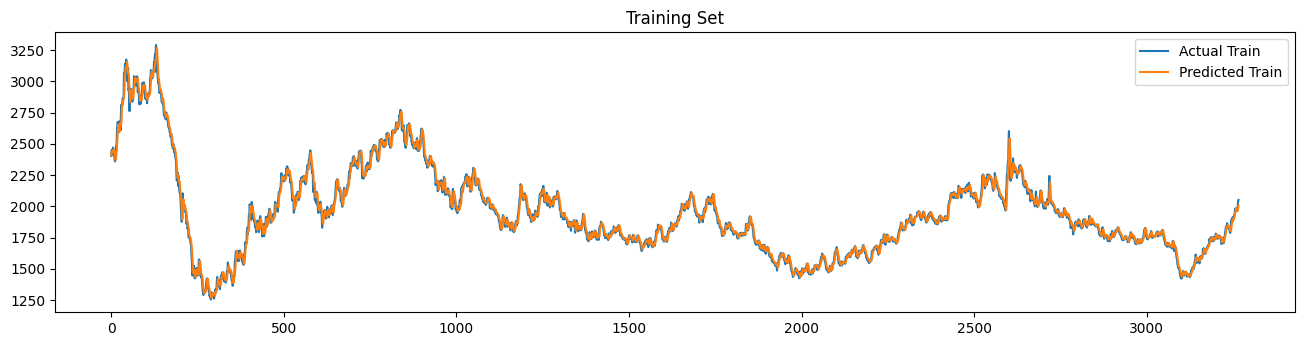

In [ ]:
# Plot predictions
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.plot(y_train, label='Actual Train')
plt.plot(train_predict, label='Predicted Train')
plt.title('Training Set')
plt.legend()

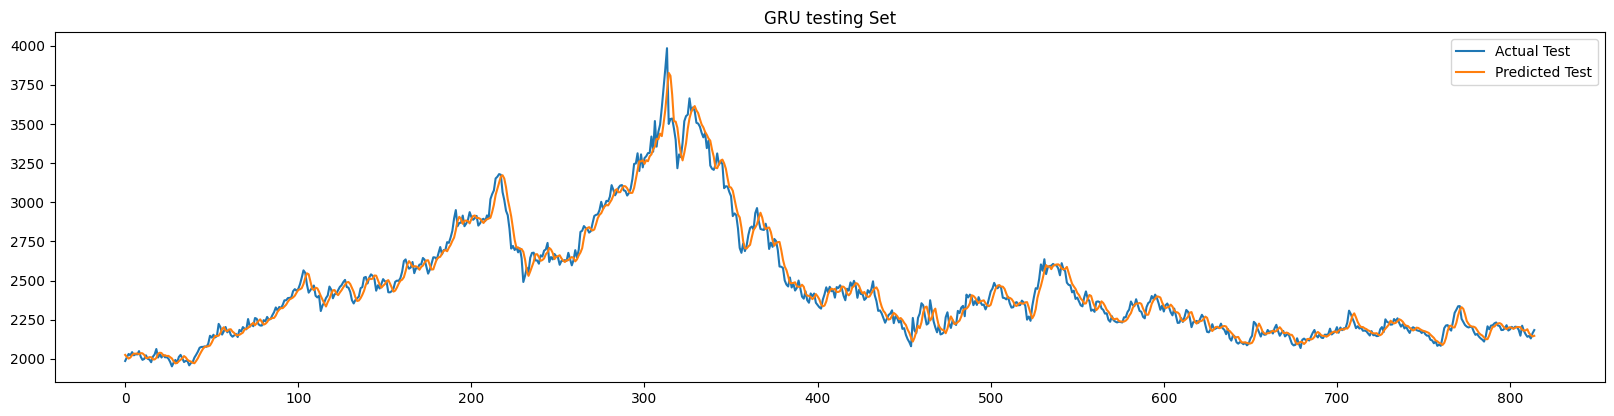

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 2)
plt.plot(y_test, label='Actual Test')
plt.plot(test_predict, label='Predicted Test')
plt.title('GRU testing Set')
plt.legend()

plt.show()